# Libraries

In [ ]:
import torch
import numpy as np
from torch import nn



# Torch vision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Import other stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tqdm.auto import tqdm

print(torch.__version__)
print(torchvision.__version__)


torch.manual_seed(42)

2.6.0+cu124
0.21.0+cu124


In [ ]:
label_dict = {
    "A" : 0,
    "B" : 1,
    "C" : 2,
    "D" : 3,
    "E" : 4,
    "F" : 5,
    "G" : 6,
    "H" : 7,
    "I" : 8,
    "J" : 9,
    "K" : 10,
    "L" : 11,
    "M" : 12,
    "N" : 13,
    "O" : 14,
    "P" : 15,
    "Q" : 16,
    "R" : 17,
    "S" : 18,
    "T" : 19,
    "U" : 20,
    "V" : 21,
    "W" : 22,
    "X" : 23,
    "Y" : 24,
    "Z" : 25,
    "del" : 26,
    "nothing" : 27,
    "space" : 28
}

In [ ]:
import kagglehub
# Download latest version

os.environ["KAGGLEHUB_CACHE_DIR"] = "/kaggle/input"

path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


# Testing



Image:  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x79D10FA665D0>


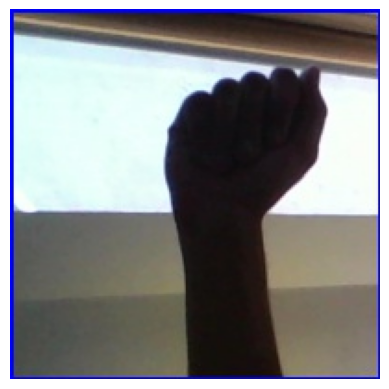

In [ ]:
from PIL import Image
image_path  = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.axis(False)
print("Image: ", img)

In [ ]:
# Transfrom PIL image to Tensor (W, H, C) -> (C, W, H)
# Normalizes/Grayscales the pixel values (200, 200, 3) -> (200, 200, 1)

transform = transforms.ToTensor()
img_tensor = transform(img)
print("Converted (Tensor) image shape: ", img_tensor.shape, img_tensor.dtype)

grayscale_img = transforms.functional.rgb_to_grayscale(img_tensor)
print("Grayscaled image shape: ", grayscale_img.shape)
print(img_tensor)

Converted (Tensor) image shape:  torch.Size([3, 200, 200]) torch.float32
Grayscaled image shape:  torch.Size([1, 200, 200])
tensor([[[0.0039, 0.0000, 0.0078,  ..., 0.0196, 0.0039, 0.0000],
         [0.0078, 0.0196, 0.0431,  ..., 0.0627, 0.0078, 0.0000],
         [0.0039, 0.0471, 0.3216,  ..., 0.4706, 0.4510, 0.0471],
         ...,
         [0.0157, 0.0392, 0.2706,  ..., 0.5216, 0.5137, 0.0510],
         [0.0039, 0.0549, 0.2196,  ..., 0.5059, 0.4549, 0.0353],
         [0.0078, 0.0078, 0.0431,  ..., 0.0431, 0.0471, 0.0078]],

        [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0196],
         [0.0039, 0.0118, 0.0275,  ..., 0.0275, 0.0118, 0.0196],
         [0.0000, 0.0314, 0.2980,  ..., 0.4392, 0.4392, 0.0471],
         ...,
         [0.0000, 0.0196, 0.2667,  ..., 0.5059, 0.5020, 0.0549],
         [0.0000, 0.0431, 0.2118,  ..., 0.5059, 0.4667, 0.0627],
         [0.0039, 0.0078, 0.0314,  ..., 0.0471, 0.0667, 0.0392]],

        [[1.0000, 0.9804, 0.9686,  ..., 0.9451, 0.9608, 0.9765],

(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

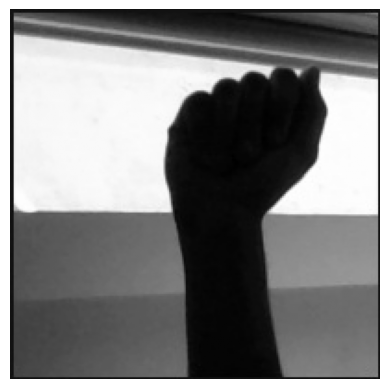

In [ ]:
plt.imshow(grayscale_img.squeeze(), cmap = "gray") # Squeeze (1, 200, 200) -> (200, 200) for matplotlib
plt.axis(False)

In [ ]:
# Overall idea
def grayscale_image(image_path):
  img = Image.open(image_path)
  transform = transforms.ToTensor()
  img_tensor = transform(img)
  grayscaled_img = transforms.functional.rgb_to_grayscale(img_tensor)
  return grayscaled_img

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

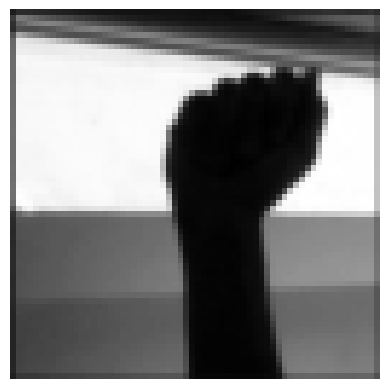

In [ ]:
# Cleaning up and using transform to do all steps (including resize)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_transform = transform(img)
plt.imshow(img_transform.squeeze(), cmap="grey")
plt.axis(False)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

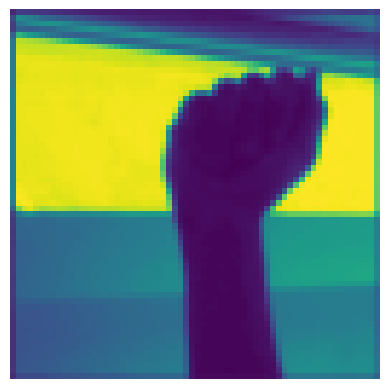

In [ ]:
generalization_transform = transforms.Compose([ # Made so model doesn't learn specifically on dataset structure(lighting, position etc.)
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),

    # PIL-only transforms
    transforms.RandomApply([
        transforms.RandomRotation(degrees=25),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4)
    ], p=0.8),

    transforms.ToTensor(),

    # Tensor-only transforms
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

img_transform = generalization_transform(img)
plt.imshow(img_transform.squeeze())
plt.axis(False)

#Import and convert data into dataloaders

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Iterate thorugh ASL train and test files and convert them to dataloaders

# Transform that will be applied on each file (through file path)
class ASLDataset(Dataset):
  def __init__(self, folder_path, label_dict, transform):
    self.data = []
    self.folder_path = folder_path
    self.label_dict = label_dict
    self.transform = transform

    # Saving tuple of file path and its label (each idx in data accessed in __getitem__ individually per batch)
    for folder in tqdm(os.listdir(folder_path), desc = "Appending directory file paths"):
      cur_path = os.path.join(folder_path, folder)
      if os.path.isdir(cur_path):
        label = label_dict[folder]
        for cur_file in tqdm(os.listdir(cur_path), desc = "Current Directory: " + cur_path):
          img_path = os.path.join(cur_path, cur_file)
          self.data.append((img_path, label))
      else:
        img = folder.split("_")
        label = label_dict[img[0]]
        self.data.append((cur_path, label))

  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    image = Image.open(img_path)
    image = self.transform(image)
    return image, label


In [ ]:
grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=25),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4)
    ], p=0.8),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_folder_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_folder_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'


train_dataset = ASLDataset(train_folder_path, label_dict, grayscale_transform)
test_dataset = ASLDataset(test_folder_path, label_dict, grayscale_transform)

Appending directory file paths:   0%|          | 0/29 [00:00<?, ?it/s]

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/R:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space:   0%|          | 0/…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/del:   0%|          | 0/30…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/E:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/M:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/X:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Q:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Y:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/S:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/G:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/O:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Z:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/L:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/W:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/D:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing:   0%|          | …

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/J:   0%|          | 0/3000…

Appending directory file paths:   0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
train_dataset.data[0:10]

[('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1337.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1637.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N20.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N222.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N2785.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N973.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1061.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N925.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1102.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N2908.jpg',
  13)]

In [ ]:
test_dataset.data[0:10]

[('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg',
  0),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg',
  4),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg',
  11),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg',
  13),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg',
  18),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg',
  3),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg',
  6),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/I_test.jpg',
  8),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/W_test.jpg',
  22),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg',
  12)]

In [ ]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4) # num_workers -> amount of subprocesses computing the data in parallel
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
train_dataloader, test_dataloader

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(<torch.utils.data.dataloader.DataLoader at 0x79d10f88f890>,
 <torch.utils.data.dataloader.DataLoader at 0x79d103d1b890>)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 64, 64]), torch.Size([128]))

Image size: torch.Size([1, 64, 64])
Label: 15, label size: torch.Size([])


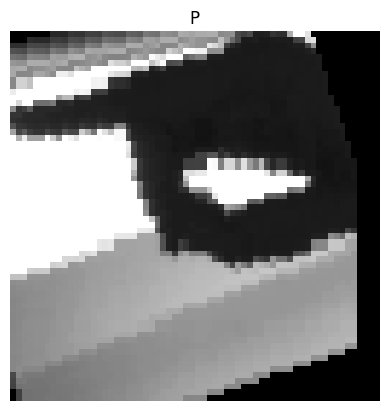

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title([key for key, val in label_dict.items() if val == label][0])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Create and CNN model

In [ ]:
hidden_features = 20
conv_block_1 = nn.Sequential(
    nn.Conv2d(1,hidden_features,3,1,1),
    nn.ReLU(),
    nn.Conv2d(hidden_features,hidden_features,3,1,1),
    nn.MaxPool2d(stride=2,kernel_size=2))

conv_block_2 = nn.Sequential(
    nn.Conv2d(hidden_features,hidden_features,3,1,1),
    nn.ReLU(),
    nn.Conv2d(hidden_features,hidden_features,3,1,1),
    nn.MaxPool2d(stride=2,kernel_size=2))

x = train_features_batch[0]

x_convolved = conv_block_1(x)
x_convolved = conv_block_2(x_convolved)

flatten_layer = nn.Flatten()
x_flattened = flatten_layer(x_convolved)

print(f'Convolution size (conv_block_1 and conv_block_2): {x_convolved.shape}')
print(f'Flattened shape for classifier: {x_flattened.shape}')

Convolution size (conv_block_1 and conv_block_2): torch.Size([20, 16, 16])
Flattened shape for classifier: torch.Size([20, 256])


In [ ]:
class ASL_MODEL(nn.Module):
  def __init__(self, input_features, hidden_features, output_features):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_features,
                  out_channels=hidden_features,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_features,
          out_channels=hidden_features,
          kernel_size=3,
          stride=1,
          padding=1),
        nn.MaxPool2d(stride=2,kernel_size=2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_features,
                    out_channels=hidden_features,
                    kernel_size=3,
                    padding=1,
                    stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_features,
            out_channels=hidden_features,
            kernel_size=3,
            stride=1,
            padding=1),
          nn.MaxPool2d(stride=2,kernel_size=2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_features*16*16, out_features=output_features))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
model = ASL_MODEL(input_features=1, hidden_features=25, output_features=len(label_dict)).to(device)
model

ASL_MODEL(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=29, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [ ]:
x = train_features_batch.to(device)
y_pred = model(x)
y_pred[0]

tensor([-0.0039,  0.0080,  0.0022,  0.0138, -0.0256, -0.0362,  0.0004,  0.0656,
        -0.0552, -0.0289,  0.0377,  0.0159, -0.0457,  0.0081, -0.0016, -0.0320,
         0.0147,  0.0565,  0.0072,  0.0331, -0.0618,  0.0404,  0.0849, -0.0388,
        -0.0138, -0.0191,  0.0125,  0.0413,  0.0124],
       grad_fn=<SelectBackward0>)

# Train the model on the dataset

In [ ]:
# Train the model

EPOCHS = 12

for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch: {epoch+1}\n-----')

  train_loss = 0

  for batch, (X, y) in tqdm(enumerate(train_dataloader), desc= "Batch Progress"):
    model.train()

    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate the loss for average

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"On batch {batch}: Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  ### TESTING
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X_test, y_test in tqdm(test_dataloader, desc="Test Batch"):

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 3.31851 | Test loss: 2.91703, Test acc: 25.00%

Epoch: 2
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 3.16552 | Test loss: 2.81472, Test acc: 25.00%

Epoch: 3
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 3.04656 | Test loss: 2.30506, Test acc: 39.29%

Epoch: 4
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 2.87653 | Test loss: 2.27982, Test acc: 32.14%

Epoch: 5
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 2.61089 | Test loss: 1.81304, Test acc: 53.57%

Epoch: 6
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 2.36340 | Test loss: 1.59979, Test acc: 46.43%

Epoch: 7
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 2.20963 | Test loss: 1.00651, Test acc: 67.86%

Epoch: 8
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 2.10022 | Test loss: 0.98897, Test acc: 82.14%

Epoch: 9
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 1.99327 | Test loss: 0.99759, Test acc: 71.43%

Epoch: 10
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 1.90968 | Test loss: 1.29757, Test acc: 60.71%

Epoch: 11
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 1.83727 | Test loss: 1.18328, Test acc: 67.86%

Epoch: 12
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 1.75964 | Test loss: 0.74931, Test acc: 82.14%



# Making predictions and evaluating the model

Text(0.5, 1.0, 'Real Label: W | Pred Label: nothing | Prob: 1.000')

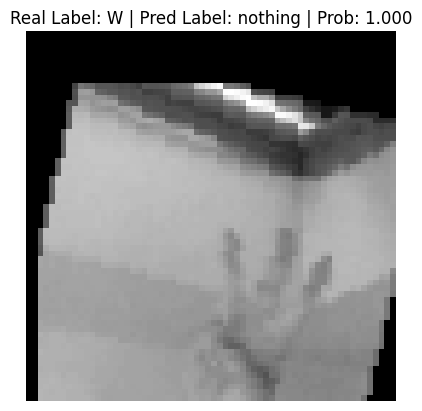

In [ ]:
# Get random test data
random_idx = torch.randint(0, len(train_features_batch), size=[1])
img, label = train_features_batch[random_idx].to(device), train_labels_batch[random_idx].to(device)

# Get models prediction
pred_tensor = pred_model(img)
pred_label = torch.softmax(pred_tensor.squeeze(), dim=0).argmax()

prob = torch.max(torch.softmax(pred_tensor, dim=1))

plt.imshow(img.squeeze().cpu(), cmap="gray")
plt.axis(False)
plt.title(f'Real Label: {[key for key, val in label_dict.items() if val == label][0]} | Pred Label: {[key for key, val in label_dict.items() if val == pred_label][0]} | Prob: {prob:.3f}')

In [ ]:
# Get list of prediction labels and true labels to compare for a confusion matrix
y_preds = []
y_truth = []
pred_model.eval()
with torch.inference_mode():
  for X, y in tqdm(train_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = pred_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred)
    y_truth.append(y) # Appending the labels to list for confusion matrix

y_pred_tensor = torch.cat(y_preds).to(device)
y_truth_tensor = torch.cat(y_truth).to(device)

Making predictions:   0%|          | 0/680 [00:00<?, ?it/s]

In [ ]:
y_pred_tensor

tensor([27, 23,  6,  ..., 27, 23,  0])

In [ ]:
y_truth_tensor

tensor([28,  8,  3,  ..., 23, 24,  0])

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 877.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
mlxtend version: 0.23.4


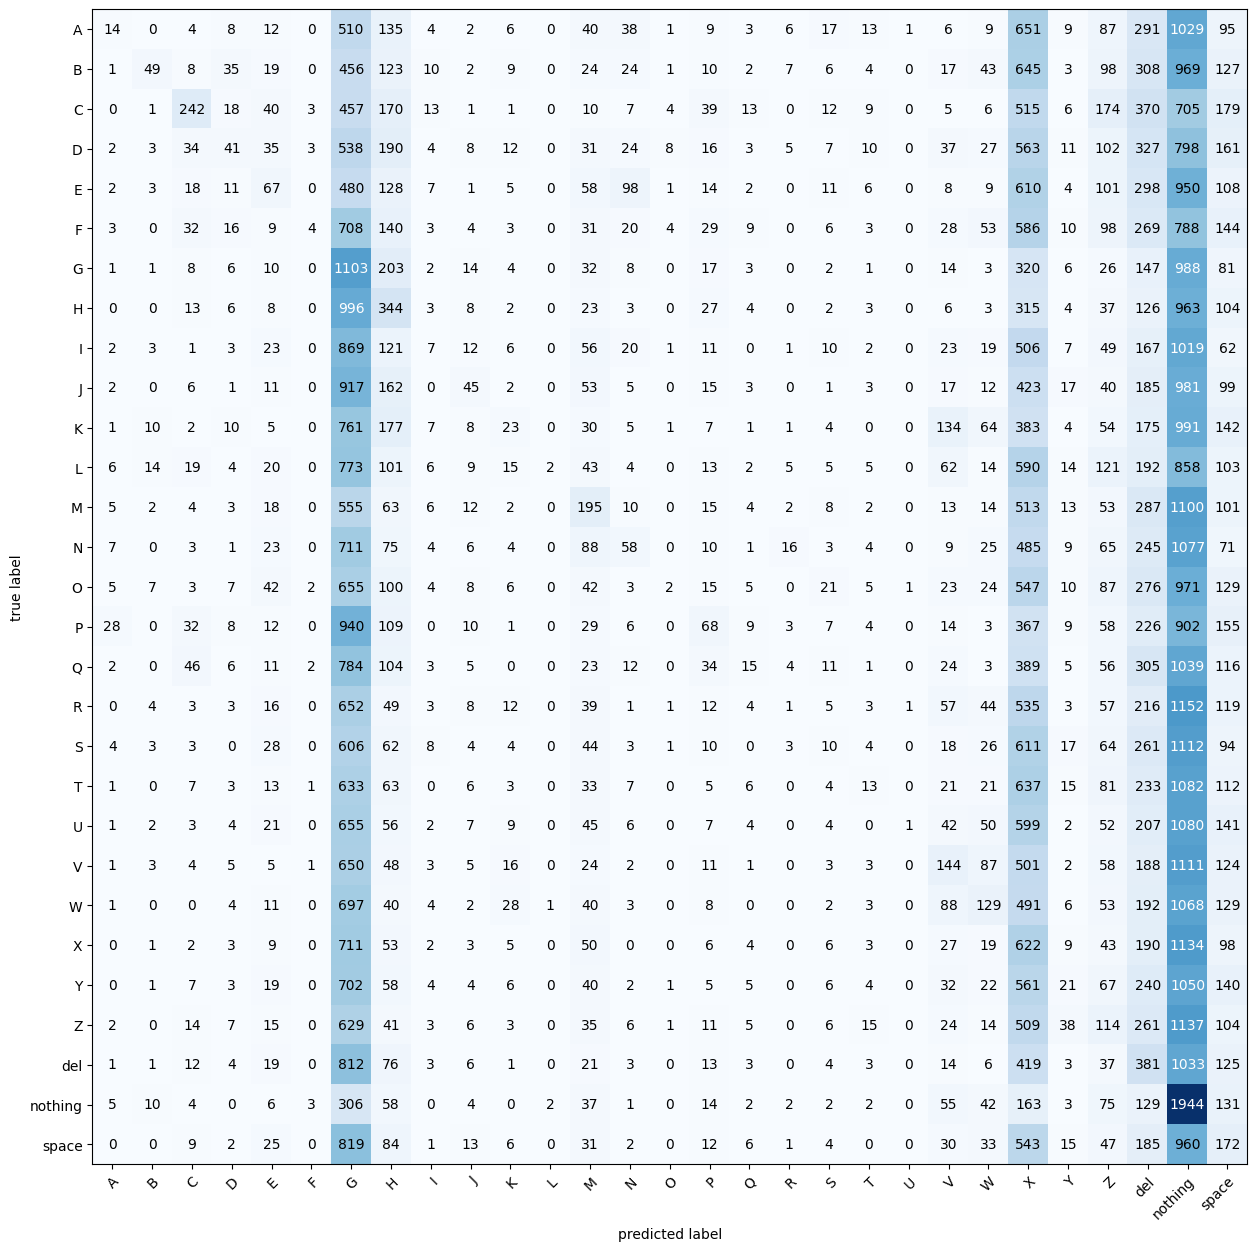

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(label_dict), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_truth_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=label_dict, # turn the row and column labels into class names
    figsize=(15, 15)
);

# Improving results with tranfer learning

In [ ]:
import torchvision.models as models

model = models.mobilenet_v3_small(weights=True).to(device)

In [ ]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
train_transform = transforms.Compose([ # Convert transform to adjust towards mobilenet_v3
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # For each channel
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model.classifier # Change to 29 classes

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [ ]:
# Freezing all parameters
for param in model.parameters():
  param.requires_grad = False

In [ ]:
for name, param in model.features.named_parameters():
  if "6" in name or "7" in name:  # Last few blocks for better training
      param.requires_grad = True

In [ ]:
model.classifier[3] = nn.Linear(in_features=1024, out_features=len(label_dict)).to(device)
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=29, bias=True)
)

In [ ]:
model = model.to(device)

In [ ]:
x = torch.randn(16, 3, 224, 224).to(device)
model(x).shape

torch.Size([16, 29])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

# Training with an `mobilenet_v3` baseline model

In [ ]:
train_folder_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_folder_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

train_dataset = ASLDataset(train_folder_path, label_dict, train_transform)
test_dataset = ASLDataset(test_folder_path, label_dict, test_transform)

Appending directory file paths:   0%|          | 0/29 [00:00<?, ?it/s]

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/R:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space:   0%|          | 0/…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/del:   0%|          | 0/30…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/E:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/M:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/X:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/K:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Q:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Y:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/S:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/G:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/O:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/V:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Z:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/L:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/W:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/D:   0%|          | 0/3000…

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing:   0%|          | …

Current Directory: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/J:   0%|          | 0/3000…

Appending directory file paths:   0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Train the model

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch: {epoch+1}\n-----')

  train_loss = 0

  for batch, (X, y) in tqdm(enumerate(train_dataloader), desc= "Batch Progress"):
    model.train()

    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate the loss for average

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"On batch {batch}: Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)

  ### TESTING
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X_test, y_test in tqdm(test_dataloader, desc="Test Batch"):

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.48313 | Test loss: 0.05853, Test acc: 100.00%

Epoch: 2
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.39425 | Test loss: 0.04554, Test acc: 100.00%

Epoch: 3
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.34813 | Test loss: 0.03797, Test acc: 100.00%

Epoch: 4
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.32521 | Test loss: 0.02846, Test acc: 100.00%

Epoch: 5
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.30761 | Test loss: 0.02965, Test acc: 100.00%

Epoch: 6
-----


Batch Progress: 0it [00:00, ?it/s]

On batch 0: Looked at 0/87000 samples
On batch 200: Looked at 25600/87000 samples
On batch 400: Looked at 51200/87000 samples
On batch 600: Looked at 76800/87000 samples


Test Batch:   0%|          | 0/1 [00:00<?, ?it/s]


Train loss: 0.29733 | Test loss: 0.02939, Test acc: 100.00%



In [ ]:
# Saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "ASL_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

In [ ]:
pred_model = models.mobilenet_v3_small(pretrained=True).to(device)
pred_model.classifier[3] = nn.Linear(in_features=1024, out_features=len(label_dict)).to(device)
pred_model.load_state_dict(torch.load('ASL_model.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

Text(0.5, 1.0, 'Real Label: S | Pred Label: Z | Prob: 0.209')

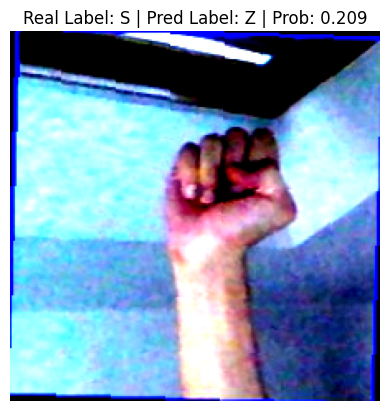

In [ ]:
# Get random test data
random_idx = torch.randint(0, len(train_features_batch), size=[1])
img, label = train_features_batch[random_idx].to(device), train_labels_batch[random_idx].to(device)

# Get models prediction
pred_tensor = pred_model(img)
pred_label = torch.softmax(pred_tensor.squeeze(), dim=0).argmax()

prob = torch.max(torch.softmax(pred_tensor, dim=1))

plt.imshow(img.squeeze().cpu().permute(1,2,0))
plt.axis(False)
plt.title(f'Real Label: {[key for key, val in label_dict.items() if val == label][0]} | Pred Label: {[key for key, val in label_dict.items() if val == pred_label][0]} | Prob: {prob:.3f}')